Based on a tutorial by Chris McCormick - http://mccormickml.com/tutorials/

In [1]:
import numpy as np
import matplotlib.cm as cm

from mpl_toolkits.mplot3d import Axes3D
from functools import partial
from matplotlib import pyplot as plt

### Plotting Functions 

In [2]:
def plot_data(X, Y, title='', c='b', m='.', ms=2, show=False):
    plt.plot(X.ravel(), Y, m, markersize=ms, c=c)
    plt.title(title)
    plt.grid()
    
    if show:
        plt.show()
        
def plot_function(X_pred, Y_pred, title='', c='b', show=False):
    plt.plot(X_pred, Y_pred, c=c)
    plt.title(title)
    plt.grid()
    
    if show:
        plt.show()
        
def scatter_plot_data(X, Y, X_p=None, model=None):
    for cat in np.unique(Y):
        cat_idx = np.where(Y == cat)[0]
        plt.plot(X[cat_idx, 0], X[cat_idx, 1], 'x', c=np.random.rand(3,1))
        
    if X_p is not None:
        plt.plot(X_p[:, 0], X_p[:, 1], 'k.', markersize=10)
        plt.axis([np.min(X[:,0]), np.max(X[:,0]), np.min(X[:,1]), np.max(X[:,1])])
    
    if model is not None:
        XX, YY = np.meshgrid(np.linspace(np.min(X[:,0]), np.max(X[:,0]), 100),
                             np.linspace(np.min(X[:,1]), np.max(X[:,1]), 100))
        X_m = np.c_[XX.ravel(), YY.ravel()] 
        Y_m = model._evaluate(X_m)
        border = np.where(abs(Y_m[:, 0] - Y_m[:, 1]) < 1e-1)
        plt.plot(X_m[border, 0], X_m[border, 1], 'k.', markersize=1)
    plt.show()

def contour_plot_data(X, Y, X_p=None, model=None, plot_3d=False):
    XX, YY = np.meshgrid(np.linspace(np.min(X[:,0]), np.max(X[:,0]), 1000),
                         np.linspace(np.min(X[:,1]), np.max(X[:,1]), 1000))
    X_m = np.c_[XX.ravel(), YY.ravel()] 
    Y_m = model._evaluate(X_m)
    
    for cat in xrange(Y_m.shape[1]):
        fig = plt.figure()
        plt.title('Category %s' % cat)
        Z = Y_m[:, cat].reshape(XX.shape)
        
        if plot_3d:
            ax = fig.gca(projection='3d')
            ax.plot_surface(XX, YY, Z, cmap=plt.cm.jet, linewidth=0, antialiased=False)
        else:
            plt.contour(XX, YY, Z)
        
        if X_p is not None and not plot_3d:
            plt.scatter(X_p[:,0], X_p[:,1], c='k', marker='x')
            plt.axis([np.min(X[:,0]), np.max(X[:,0]), np.min(X[:,1]), np.max(X[:,1])])
        
    plt.show()

## Base RBF class

In [3]:
def rb_func(X, proto, beta):
    return np.exp(-beta * np.linalg.norm(X-proto, 2, axis=1)**2)

def gaussian_func(X, mu=0.0, sigma=1.0):
    return 1. / (sigma*np.sqrt(2*np.pi)) * np.exp(-np.linalg.norm(X-mu, axis=1)**2 / (2*sigma**2))

In [4]:
class RBFBaseNet(object):
    def __init__(self, prototypes, betas):
        self._h_units = partial(rb_func, proto=prototypes, beta=betas)
        self._h_size = betas.shape[0]
        self._Ws = None
    
    def _evaluate(self, X, normalize=False):
        return self._hidden_activation(X, normalize).dot(self._Ws)
    
    def _hidden_activation(self, X, normalize=False):
        activations = np.array([self._h_units(x) for x in X])
        if normalize:
            activations /= np.sum(activations, axis=1, dtype=np.float32).reshape(-1,1) 
        return np.hstack((activations, np.ones((activations.shape[0], 1))))
    
    def train(self, X, Y):
        pass
    
    def predict(self, X):
        pass

## RBF for Classification

In [5]:
class RBFClassificationNet(RBFBaseNet):
    def train(self, X, Y):
        unique_cats = np.unique(Y).shape[0]
        self._Ws = np.empty((self._h_size+1, unique_cats))
        activations = self._hidden_activation(X)
        
        for c_idx in xrange(unique_cats):
            Y_c = Y == (c_idx+1)
            self._Ws[:, c_idx] = np.linalg.pinv(activations.T.dot(activations)).dot(activations.T).dot(Y_c)
        return self._evaluate(X)
       
    def predict(self, X):
        return np.argmax(self._evaluate(X), axis=1)+1

#### Experiments

In [6]:
# perfect settings
X_prototypes = np.array([[-0.438797, -0.892736], [1.249907, -0.343441],
                         [0.944767, -1.339304], [-0.721325, 0.775050],
                         [0.464235, 0.737062], [-0.142028, -0.237460],
                         [0.588415, 0.088941], [-0.221125, -1.620912], 
                         [-0.892999, 0.316725], [-0.816163, -0.229059],
                         [-0.753473, 1.484120], [-1.452561, 1.009876],
                         [0.265144, -1.070498], [-0.029990, 1.460350],
                         [-1.342123, -1.100056], [1.329630, 0.749909],
                         [0.833425, 1.387484], [-0.119146, 0.726737],
                         [-1.523310, 0.014237], [1.721531, -1.261012]])

betas = np.array([9.2634, 3.9628, 3.8224, 9.6673, 8.5243, 7.5800, 
                  8.0549, 3.5956, 9.9555, 7.4837, 8.8154, 6.5044, 
                  3.1812, 7.1897, 3.8088, 5.2297, 6.5097, 7.4958, 
                  4.7029, 4.4208])

In [7]:
# load and split data
with open('dataset.csv') as fd:
    data = np.array([[float(x) for x in line.split(',')] for line in fd])
X, Y = data[:, :2], data[:, 2]

# draw prototypes
num_proto = 20
permut = np.random.permutation(X.shape[0])[:num_proto]

# X_prototypes = X[permut,:]
# Y_prototypes = Y[permut]
# betas = np.ones(X_prototypes.shape[0]) * 6.5

# run algorithm
rbf_classify = RBFClassificationNet(X_prototypes, betas)
rbf_classify.train(X, Y).shape
print 'Accuracy: {}'.format(sum(Y == rbf_classify.predict(X)) / float(Y.shape[0]))

Accuracy: 0.953650057937


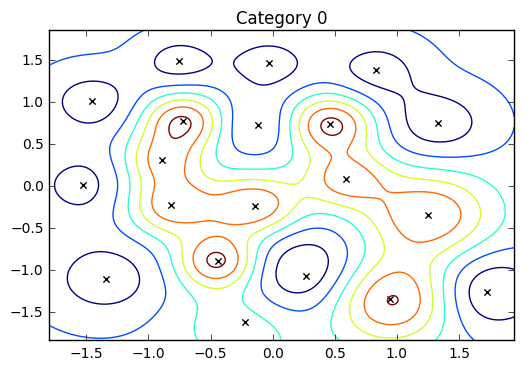

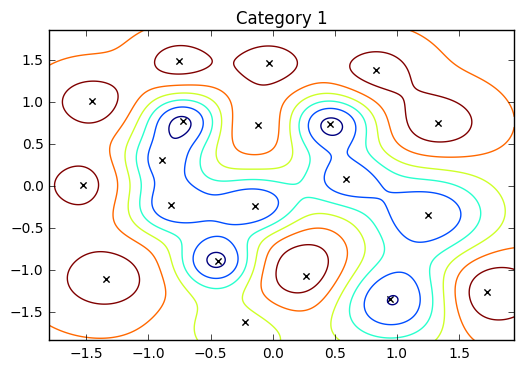

In [8]:
# scatter_plot_data(X, Y, X_prototypes, rbf_net)
contour_plot_data(X, Y, X_prototypes, rbf_classify)

## RBF for Regression

In [9]:
class RBFRegressionNet(RBFBaseNet):
    def train(self, X, Y):
        self._Ws = np.empty(self._h_size+1)
        activations = self._hidden_activation(X, True)
        self._Ws = np.linalg.pinv(activations.T.dot(activations)).dot(activations.T).dot(Y)
        return self._evaluate(X, True)
    
    def train_online(self, x, y, eta=0.05, init_weights=False):
        if init_weights:
            self._Ws = np.random.rand(self._h_size+1)
        activations = self._hidden_activation(x, True)
        self._Ws += eta * (y - self._evaluate(x, True)) * activations.reshape(-1,)
    
    def predict(self, X):
        return self._evaluate(X, True)

#### Experiments

In [10]:
func = np.vectorize(lambda x: 0.5*x**3 + 4*x**2 + 7*x)

# generate data
data_size = 1000
X_full = np.linspace(-5, 0, data_size).reshape(-1, 1)
Y_full = np.array([func(x) + np.random.normal() for x in X_full])

permut = np.random.permutation(X_full.shape[0])
X_train = X_full[permut][:int(data_size*0.7)]
Y_train = Y_full[permut][:int(data_size*0.7)]

# draw prototypes
num_proto = 10
permut = np.random.permutation(X_train.shape[0])[:num_proto]
X_prototypes = X_train[permut]
Y_prototypes = Y_train[permut]
betas = np.ones(X_prototypes.shape[0]) * 0.5

# run batch algorithm
rbf_reg = RBFRegressionNet(X_prototypes, betas)
rbf_reg.train(X_train, Y_train).shape
Y_pred = rbf_reg.predict(X_full)

# run delta algorithm
rbf_reg_i = RBFRegressionNet(X_prototypes, betas)
eta_param = 0.07
rbf_reg_i.train_online(X_train[0], Y_train[0], eta_param, init_weights=True)
for idx in xrange(1, X_train.shape[0]):
    rbf_reg_i.train_online(X_train[idx], Y_train[idx], eta_param)
for idx in xrange(1, X_train.shape[0]):
    rbf_reg_i.train_online(X_train[idx], Y_train[idx], eta_param)
Y_pred_i = rbf_reg_i.predict(X_full)

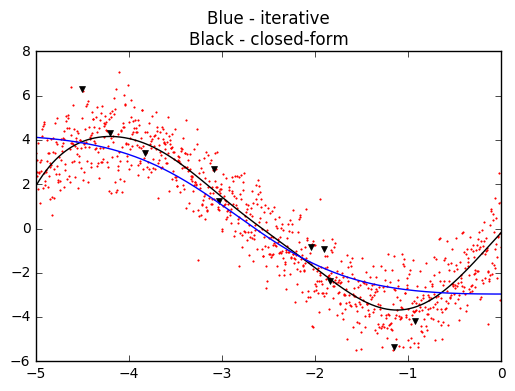

In [11]:
plot_data(X_full, Y_full, c='r', show=False)
plot_data(X_prototypes, Y_prototypes, c='k', m='v', ms=5, show=False)
plot_function(X_full, Y_pred, c='k', show=False)
plot_function(X_full, Y_pred_i, title='Blue - iterative\nBlack - closed-form', c='b', show=True)

## School work

In [33]:
X = np.array([[1, 1], [1, -1], [-1, 1], [-1, -1]])
Y = np.array([1, 2, 2, 1])

# draw prototypes
num_proto = 2
permut = np.random.permutation(X.shape[0])[:num_proto]

X_prototypes = X[permut,:]
Y_prototypes = Y[permut]
betas = np.ones(X_prototypes.shape[0]) * 2.5

# run algorithm
rbf_classify = RBFClassificationNet(X_prototypes, betas)
rbf_classify.train(X, Y).shape
print 'Accuracy: {}'.format(sum(Y == rbf_classify.predict(X)) / float(Y.shape[0]))

Accuracy: 0.5


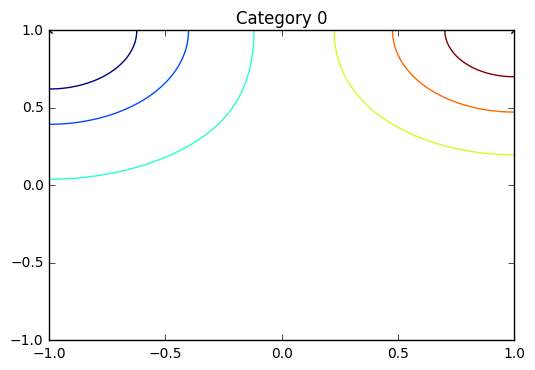

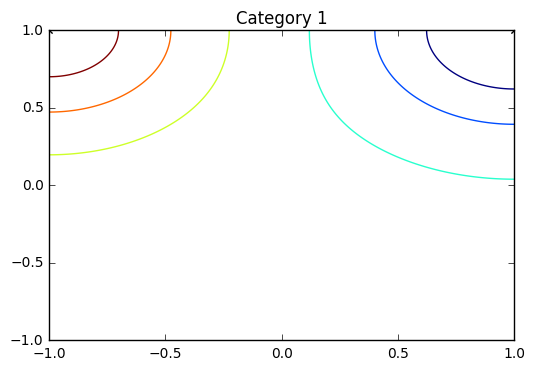

In [34]:
# scatter_plot_data(X, Y, X_prototypes, rbf_classify)
contour_plot_data(X, Y, X_prototypes, rbf_classify)

In [23]:
np.linspace(0, 2*np.pi, 4)

array([ 0.        ,  2.0943951 ,  4.1887902 ,  6.28318531])